Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
# Load the dataset
df_pd = pd.read_csv("bank-additional-full.csv", sep=';')
df = df_pd.copy()

In [3]:
df.head

<bound method NDFrame.head of        age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact mont

In [4]:
#Check of Duplicates and remove them
duplicates = df.duplicated()
print(duplicates.sum())
df = df.drop_duplicates()
df.shape

12


(41176, 21)

In [5]:
# Check for unique values in categorical columns
for col in df.select_dtypes("object").columns:
    print(f"Unique values in {col}:")
    print(df[col].unique(), "\n")

Unique values in job:
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student'] 

Unique values in marital:
['married' 'single' 'divorced' 'unknown'] 

Unique values in education:
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate'] 

Unique values in default:
['no' 'unknown' 'yes'] 

Unique values in housing:
['no' 'yes' 'unknown'] 

Unique values in loan:
['no' 'yes' 'unknown'] 

Unique values in contact:
['telephone' 'cellular'] 

Unique values in month:
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep'] 

Unique values in day_of_week:
['mon' 'tue' 'wed' 'thu' 'fri'] 

Unique values in poutcome:
['nonexistent' 'failure' 'success'] 

Unique values in y:
['no' 'yes'] 



In [6]:
# Define a function to identify outliers
def get_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound, ((series < lower_bound) | (series > upper_bound)).sum()

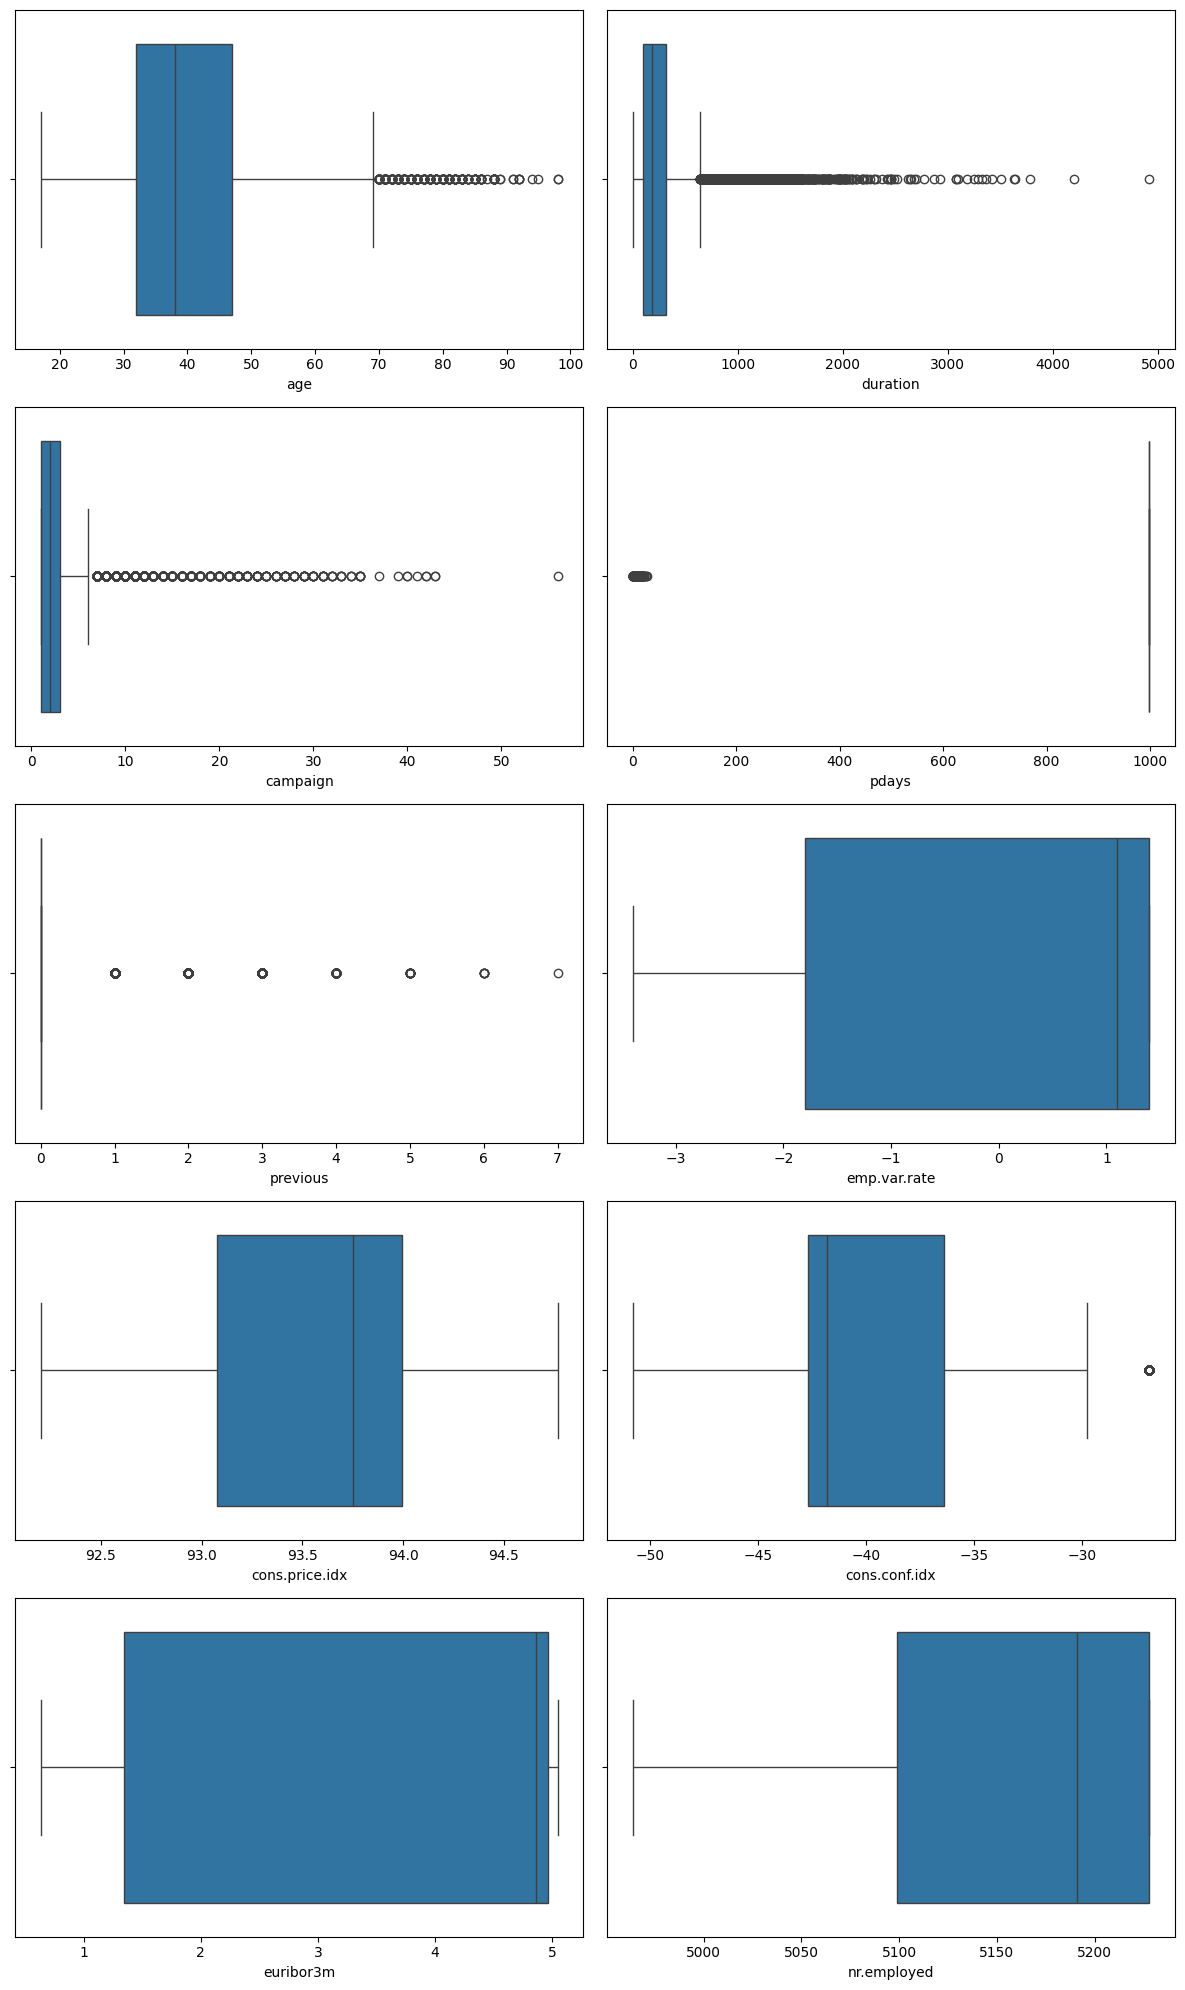

In [7]:
# Visualize numerical columns
numerical_columns = df.select_dtypes("number").columns
fig, axes = plt.subplots(nrows=len(numerical_columns) // 2, ncols=2, figsize=(12, len(numerical_columns) * 2))
axes = axes.flatten()
for i, col in enumerate(numerical_columns):
    sns.boxplot(x=df[col], ax=axes[i])
plt.tight_layout()
plt.show()

In [8]:
# Outlier analysis: Age
print(f"Outliers in age: {get_outliers(df['age'])[2]}")
print(f"Maximum age: {df['age'].max()}")

Outliers in age: 468
Maximum age: 98


In [9]:
# Handling 'campaign'
campaign_median = df['campaign'].median()
campaign_lb, campaign_ub, _ = get_outliers(df['campaign'])
df.loc[:, 'campaign'] = np.where((df['campaign'] < campaign_lb) | (df['campaign'] > campaign_ub), campaign_median, df['campaign'])

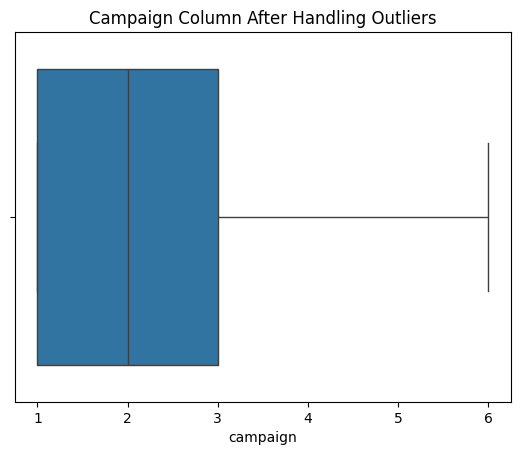

In [10]:
sns.boxplot(x=df["campaign"])
plt.title("Campaign Column After Handling Outliers")
plt.show()

In [11]:
# Handle 'pdays' and 'previous'
if 'pdays' in df.columns and 'previous' in df.columns:
    # Create a new feature for clients not contacted previously
    df.loc[:, 'pdays_999'] = (df['pdays'] == 999)

    # Remove rows where pdays is 999 but 'previous' is greater than 0
    df = df[~((df['pdays'] == 999) & (df['previous'] > 0))]

    # Drop 'pdays' and 'previous' columns
    df.drop(columns=['pdays', 'previous'], inplace=True)

C:\Users\Asus\AppData\Local\Temp\ipykernel_32832\3432199483.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'pdays_999'] = (df['pdays'] == 999)


In [12]:
#outliers in cons.conf.idx
print("Number of outliers in cons.conf.idx",get_outliers(df["cons.conf.idx"])[2])

#maximum
print("Maximum cons.conf.idx value: ", df["cons.conf.idx"].max())

#upper bound
print("Upper bound: ", get_outliers(df["cons.conf.idx"])[1])


#checking the outlier values
df[df["cons.conf.idx"] > get_outliers(df["cons.conf.idx"])[1]]["cons.conf.idx"].value_counts()

Number of outliers in cons.conf.idx 348
Maximum cons.conf.idx value:  -26.9
Upper bound:  -26.949999999999992


cons.conf.idx
-26.9    348
Name: count, dtype: int64

In [13]:
df.drop(columns=['duration'], inplace=True)

In [14]:
# Analyze columns with 'unknown' values
unknown_info = []
for col in df.columns:
    if 'unknown' in df[col].values:
        unknown_info.append((col, df[col].value_counts()['unknown'] / len(df) * 100))
for col, percent in unknown_info:
    print(f"{col}: {percent:.2f}% unknown values")

job: 0.84% unknown values
marital: 0.18% unknown values
education: 4.20% unknown values
default: 21.81% unknown values
housing: 2.39% unknown values
loan: 2.39% unknown values


In [15]:
# Drop columns or rows with high 'unknown' values
df = df[df["job"] != "unknown"]
df = df[df["marital"] != "unknown"]
df = df[df["education"] != "unknown"]
df = df[df["housing"] != "unknown"]
df = df[df["loan"] != "unknown"]
df.drop(columns=['default'], inplace=True)

In [16]:
# Class balance check
class_counts = df['y'].value_counts()
print("Class counts:")
print(class_counts)
print(f"Class imbalance ratio: {class_counts.iloc[0] / len(df):.3f} : {class_counts.iloc[1] / len(df):.3f}")

Class counts:
y
no     30635
yes     3786
Name: count, dtype: int64
Class imbalance ratio: 0.890 : 0.110


In [17]:
# Encode target variable
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['y'] = label_encoder.fit_transform(df['y'])

In [18]:
# One-hot encoding for categorical variables
df = pd.get_dummies(df, columns=['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'], drop_first=True)

In [19]:
# Feature matrix and target variable
X = df.drop(columns=['y'])
y = df['y']

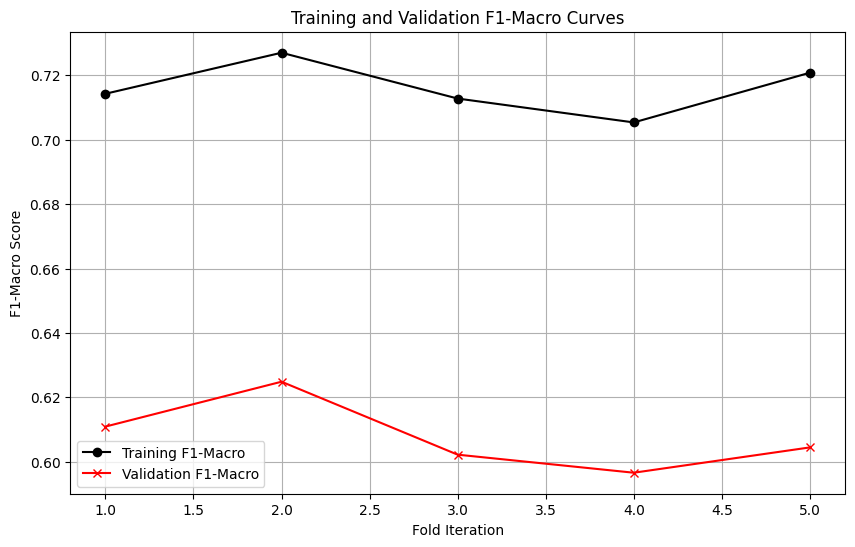

Mean Training F1-Macro: 0.716
Mean Validation F1-Macro: 0.608


In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Define pipeline steps and create the pipeline
pipeline_steps = [
    ('oversample', RandomOverSampler()), 
    ('scaler', StandardScaler()),  # Add scaler to standardize the data
    ('classifier', MLPClassifier(max_iter=500, random_state=1, learning_rate_init=0.001, hidden_layer_sizes=(50,)))
]
pipeline = Pipeline(steps=pipeline_steps)

# Define Repeated Stratified K-Fold cross-validation strategy
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)  # Reduced folds and repeats

# Initialize lists to store F1-macro scores
train_scores = []
val_scores = []

# Perform manual cross-validation to compute training and validation scores
for train_idx, val_idx in cv_strategy.split(X, y):
    # Split data into training and validation sets
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    # Predict and evaluate on the training data
    y_train_pred = pipeline.predict(X_train)
    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    train_scores.append(train_f1)
    
    # Predict and evaluate on the validation data
    y_val_pred = pipeline.predict(X_val)
    val_f1 = f1_score(y_val, y_val_pred, average='macro')
    val_scores.append(val_f1)

# Convert scores to numpy arrays for easier calculations
train_scores = np.array(train_scores)
val_scores = np.array(val_scores)

# Plot the training and validation F1-macro scores
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(train_scores) + 1), train_scores, 
    label="Training F1-Macro", color='black', linestyle="-", marker='o'
)
plt.plot(
    range(1, len(val_scores) + 1), val_scores, 
    label="Validation F1-Macro", color='red', linestyle='-', marker="x"
)

plt.title('Training and Validation F1-Macro Curves')
plt.xlabel('Fold Iteration')
plt.ylabel('F1-Macro Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Calculate and print the mean F1-macro scores
print(f'Mean Training F1-Macro: {train_scores.mean():.3f}')
print(f'Mean Validation F1-Macro: {val_scores.mean():.3f}')


In [21]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
import pandas as pd

# Initialize the MLPClassifier model with early stopping and increased tolerance for quicker convergence
mlp = MLPClassifier(random_state=42, max_iter=500, early_stopping=True, tol=1e-4)

# Specify the grid of hyperparameters to tune for the neural network
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,)],  # Reduced the grid for faster execution
    'mlp__activation': ['relu'],  # Limited activation functions
    'mlp__solver': ['adam'],  # Fixed solver to 'adam' for simplicity
    'mlp__learning_rate_init': [0.001]  # Fixed learning rate for faster tuning
}

# Stratified K-Fold to ensure balanced splits for cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reduced the number of folds to 3

# Custom scoring metric using F1-Macro for multi-class classification
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Create a pipeline combining RandomOverSampler and MLPClassifier
pipeline = Pipeline(steps=[
    ('ros', RandomOverSampler(random_state=42)), 
    ('mlp', mlp)
])

# Configure GridSearchCV to find the best hyperparameters, using parallel processing
grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid, 
    cv=cv, 
    scoring=f1_macro_scorer, 
    return_train_score=True,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search process to the data
grid_search.fit(X, y)  # Ensure 'X' and 'y' are your prepared data

# Extract results and organize into a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Select and sort the relevant columns for analysis
final_results = results[['params', 'mean_train_score', 'mean_test_score']].sort_values(
    by='mean_test_score', 
    ascending=False
)

# Display the sorted results
print(final_results)


                                              params  mean_train_score  \
1  {'mlp__activation': 'relu', 'mlp__hidden_layer...          0.657219   
0  {'mlp__activation': 'relu', 'mlp__hidden_layer...          0.653971   

   mean_test_score  
1         0.655597  
0         0.652184  


In [ ]:
# Extract the best model's details from the final_results DataFrame
best_model = final_results.iloc[0]  # Assuming final_results is sorted by 'mean_test_score' descending

# Print the best model's details
print("Best Model Details:")
print(f"Parameters: {best_model['params']}")
print(f"Mean Train Score: {best_model['mean_train_score']}")
print(f"Mean Test Score: {best_model['mean_test_score']}")


In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt

# Splitting the dataset into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Applying RandomOverSampler to balance the training dataset
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Retrieving the best model from the grid search
best_model = grid_search.best_estimator_

# Training the best model on the resampled training data
best_model.fit(X_train_resampled, y_train_resampled)

# Making predictions on the test set
y_pred = best_model.predict(X_test)

# Getting predicted probabilities for the positive class (class 1)
y_prob = best_model.predict_proba(X_test)[:, 1]  # Assuming class 1 is positive

# Generating a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculating the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Computing the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(
    fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})'
)
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')  # Diagonal line as baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

# Define a pipeline with under-sampling and a Random Forest classifier
pipeline_steps = [
    ('undersample', RandomUnderSampler()), 
    ('classifier', RandomForestClassifier())
]
pipeline = Pipeline(steps=pipeline_steps)

# Define Repeated Stratified K-Fold cross-validation strategy
cv_strategy = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Lists to store F1-macro scores for training and validation
train_scores = []
val_scores = []

# Perform manual cross-validation to calculate training and validation scores
for train_idx, val_idx in cv_strategy.split(X, y):
    # Split dataset into training and validation sets
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Fit the pipeline on the training set
    pipeline.fit(X_train, y_train)

    # Evaluate F1-macro score on the training set
    y_train_pred = pipeline.predict(X_train)
    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    train_scores.append(train_f1)

    # Evaluate F1-macro score on the validation set
    y_val_pred = pipeline.predict(X_val)
    val_f1 = f1_score(y_val, y_val_pred, average='macro')
    val_scores.append(val_f1)

# Convert scores to numpy arrays for easier statistical analysis
train_scores = np.array(train_scores)
val_scores = np.array(val_scores)

# Plot training and validation F1-macro scores across folds
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(train_scores) + 1), train_scores, label="Training F1-Macro", 
    color="black", linestyle="-", marker='o'
)
plt.plot(
    range(1, len(val_scores) + 1), val_scores, label="Validation F1-Macro", 
    color='blue', linestyle="-", marker='x'
)
plt.title('Training and Validation F1-Macro Curves')
plt.xlabel('Fold Iteration')
plt.ylabel('F1-Macro Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Calculate and display the mean F1-macro scores for training and validation
print(f'Mean Training F1-Macro: {train_scores.mean():.3f}')
print(f'Mean Validation F1-Macro: {val_scores.mean():.3f}')


In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

# Define the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'rf__n_estimators': [5, 9, 15],  # Corrected prefix to match pipeline naming
    'rf__max_depth': [5, 10],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Define Stratified K-Fold cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring function for F1-Macro
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Set up a pipeline with RandomUnderSampler and Random Forest classifier
pipeline = Pipeline(steps=[
    ('undersample', RandomUnderSampler(random_state=42)), 
    ('rf', rf)
])

# Set up GridSearchCV with the pipeline and hyperparameter grid
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=f1_macro_scorer,
    return_train_score=True
)

# Fit the grid search on the dataset
grid_search.fit(X, y)  # Assuming X and y are your features and target variable

# Display results in a DataFrame format
results = pd.DataFrame(grid_search.cv_results_)

# Display only relevant columns: params, mean_train_score, and mean_test_score
relevant_results = results[['params', 'mean_train_score', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)

# Print the sorted results
print(relevant_results)

# Extract and print the best model's details
best_model = grid_search.best_estimator_
print("Best Model Details:")
print(f"Parameters: {grid_search.best_params_}")
print(f"Mean Train Score: {grid_search.best_score_}")
